# This notebook is used to evaluate trained model a

## Example: Raleigh

We now use Raleigh, which is the first as well as trained scenario for testing. Trained models should be evaluated in more scenario in the future

In [1]:
# we need to check if we are using the same conda env as training, which is modelA_sb3

import sys, os
from pathlib import Path
print("sys.executable =", sys.executable)
print("python version =", sys.version)
print("cwd =", os.getcwd())

# Project root
PROJECT_ROOT = Path("/home/jhuang52/Projects/metaRL_merged")

# Ensure we can import project modules
sys.path.insert(0, str(PROJECT_ROOT))

sys.executable = /home/jhuang52/miniconda3/envs/modelA_sb3/bin/python
python version = 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
cwd = /data/jhuang52/Projects/metaRL_merged/eval_tools/model_a


In [2]:
from pathlib import Path
import sys

PROJECT_ROOT = Path("/home/jhuang52/Projects/metaRL_merged").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

from eval_tools.model_a.model_a_functions import (
    generate_gu_trajectory_csv,
    make_gu_trajectory_gif_2d,
    evaluate_over_trajectory_csv,
    save_eval_csv,
    visualize_scene_2d,
    visualize_scene_3d,
    load_gu_trajectory_csv,
    evaluate_over_trajectory_csv_envstep,
    resolve_cfg_paths,
    load_json,
    compute_metrics_from_sinr
)

# CFG_PATH = PROJECT_ROOT / "inner_loop/model_a/configs/raleigh_modelA.json"
# CFG_PATH = PROJECT_ROOT / "inner_loop/model_a/configs/raleigh_modelA-test.json"
CFG_PATH = PROJECT_ROOT / "inner_loop/model_a/configs/open_modelA.json"

# MODEL_ZIP = PROJECT_ROOT / "inner_loop/model_a/runs/modelA_sb3/SAC_20260128_171021/sac_final.zip"
MODEL_ZIP = PROJECT_ROOT / "inner_loop/model_a/runs/modelA_sb3/SAC_20260218_185744/sac_final.zip"
gu_traj_csv = PROJECT_ROOT / "eval_tools/gu_trajectories/gus_traj_raleigh_T50.csv"

# CFG_PATH = PROJECT_ROOT / "inner_loop/model_a/configs/atlanta_modelA.json"
# MODEL_ZIP = PROJECT_ROOT / "inner_loop/model_a/runs/modelA_sb3/SAC_20260206_002838/sac_final.zip"
# gu_traj_csv = PROJECT_ROOT / "eval_tools/gu_trajectories/gus_traj_atlanta_T50.csv"

In [3]:
import pandas as pd
import numpy as np

df_csv = pd.read_csv(gu_traj_csv)
print("CSV rows:", len(df_csv))
print("CSV unique t:", df_csv["t"].nunique(), "t min/max:", df_csv["t"].min(), df_csv["t"].max())
print("CSV unique gu_id:", df_csv["gu_id"].nunique(), "gu_id min/max:", df_csv["gu_id"].min(), df_csv["gu_id"].max())

# 检查每个 t 是否都有 150 行
counts = df_csv.groupby("t")["gu_id"].count()
print("per-t count min/max:", counts.min(), counts.max())
bad_ts = counts[counts != counts.max()]
print("bad t (count != max):", bad_ts.head(10).to_dict())


CSV rows: 7500
CSV unique t: 50 t min/max: 0 49
CSV unique gu_id: 150 gu_id min/max: 0 149
per-t count min/max: 150 150
bad t (count != max): {}


In [4]:
# ===== Notebook Evaluation Cell (Model A, CSV-driven, env.step() as source of truth) =====

import numpy as np

# 1) build env_ctor: you MUST point to your actual Model-A gym env class
# Example: from inner_loop.model_a.envs.placement_env import SionnaPlacementEnv
from inner_loop.model_a.envs.placement_env import SionnaPlacementEnv # <-- CHANGE to your real env class import

def env_ctor(cfg_dict):
    # cfg_dict is resolved cfg from JSON (dict)
    return SionnaPlacementEnv(cfg_dict)

2026-02-19 17:11:01.167810: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-19 17:11:01.207955: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jhuang52/miniconda3/envs/modelA_sb3/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  wa

In [5]:
import numpy as np

# 0) load cfg / model / traj
cfg_dict = resolve_cfg_paths(load_json(CFG_PATH))
traj = load_gu_trajectory_csv(gu_traj_csv)
print("traj shape:", traj.shape)  # expect (50,150,3)

# 1) build env (IMPORTANT: call reset())
env = env_ctor(cfg_dict)
print("env class:", env.__class__.__name__)

obs0, info0 = env.reset()
print("reset obs len:", len(obs0))
# print("model expects:", model.observation_space.shape)

print("env.n_uav:", getattr(env, "n_uav", None))
print("env.n_gu:", getattr(env, "n_gu", None))

raw = getattr(env, "env_raw", None)
print("has env_raw:", raw is not None)
if raw is not None:
    print("env_raw.n_rx:", getattr(raw, "n_rx", None), "env_raw.n_tx:", getattr(raw, "n_tx", None))
    print("len(env_raw.gus):", len(getattr(raw, "gus", [])))

# 2) check current GU/UAV arrays used for obs
u0 = env._get_uav_xyz()
g0 = env._get_gu_xyz()
print("uav xyz shape:", u0.shape, "=> uav part len:", u0.reshape(-1).shape[0])
print("gu  xyz shape:", g0.shape, "=> gu  part len:", g0.reshape(-1).shape[0])
print("built obs len (from env):", env._build_obs().shape[0])

# 3) now inject CSV GU positions and re-check
gu_xyz = traj[0].astype(np.float32)
print("CSV gu_xyz shape:", gu_xyz.shape)

env.set_gu_xyz(gu_xyz)

g1 = env._get_gu_xyz()
print("after set_gu_xyz -> gu xyz shape:", g1.shape, "=> gu part len:", g1.reshape(-1).shape[0])
print("built obs len (after set):", env._build_obs().shape[0])


traj shape: (50, 150, 3)
env class: SionnaPlacementEnv
reset obs len: 465
env.n_uav: 5
env.n_gu: 150
has env_raw: True
env_raw.n_rx: 150 env_raw.n_tx: 5
len(env_raw.gus): 150
uav xyz shape: (5, 3) => uav part len: 15
gu  xyz shape: (150, 3) => gu  part len: 450
built obs len (from env): 465
CSV gu_xyz shape: (150, 3)
after set_gu_xyz -> gu xyz shape: (150, 3) => gu part len: 450
built obs len (after set): 465


In [6]:
# # ===== Notebook Evaluation Cell (Model A, CSV-driven, env.step() as source of truth) =====

# import numpy as np

# # 1) build env_ctor: you MUST point to your actual Model-A gym env class
# # Example: from inner_loop.model_a.envs.placement_env import SionnaPlacementEnv
# from inner_loop.model_a.envs.placement_env import SionnaPlacementEnv # <-- CHANGE to your real env class import

# def env_ctor(cfg_dict):
#     # cfg_dict is resolved cfg from JSON (dict)
#     return SionnaPlacementEnv(cfg_dict)

# 2) run evaluation (multi-step, return sinr + radiomap through info/cache)
df, cache = evaluate_over_trajectory_csv_envstep(
    cfg_path=CFG_PATH,
    model_zip_path=MODEL_ZIP,
    gu_traj_csv=gu_traj_csv,
    env_ctor=env_ctor,
    t_start=0,
    t_end=50,
    deterministic=True,
    action_mode="absolute",   # kept for compatibility; env action space should already match training
    save_cache=True,
)

display(df.head(10))

# 3) quick sanity checks: what did we actually cache?
print("cache keys:", None if cache is None else list(cache.keys()))
if cache is not None:
    t0 = int(df["t"].iloc[0])
    print("example t:", t0)
    print("uav_xyz[t].shape:", cache["uav_xyz"][t0].shape)
    print("gu_xyz[t].shape:", cache["gu_xyz"][t0].shape)
    print("sinr_db_gu_tx[t].shape:", cache["sinr_db_gu_tx"][t0].shape)
    print("has radio_map[t]:", t0 in cache.get("radio_map", {}))

# 4) access radiomap / sinr for a specific step t
t_pick = 0
sinr_db_gu_tx = None if cache is None else cache["sinr_db_gu_tx"][t_pick]
radio_map = None if cache is None else cache.get("radio_map", {}).get(t_pick, None)

print("t_pick =", t_pick)
print("sinr_db_gu_tx:", None if sinr_db_gu_tx is None else sinr_db_gu_tx.shape)
print("radio_map:", type(radio_map))

,t,reward,invalid_uav_count,coverage_tau_db,coverage_count,coverage_ratio,best_sinr_mean,best_sinr_min,best_sinr_max,load_var,...,rinfo/sinr_offset_clip_low_db,rinfo/sinr_offset_clip_high_db,rinfo/best_sinr_db_max,rinfo/best_sinr_db_mean,rinfo/best_sinr_db_min,rinfo/load_var,rinfo/per_uav_load_max,rinfo/per_uav_load_mean,rinfo/per_uav_load_min,rinfo/invalid_uav_count
0,0,-39.600132,0,5.0,13,0.086667,-1.860381,-300.000031,51.119686,167.959198,...,-20.0,20.0,51.119686,-1.860381,-300.000031,167.959198,49.0,20.400000,6.0,0.0
1,1,-43.802037,0,5.0,13,0.086667,-0.359494,-5.934596,48.733543,197.387741,...,-20.0,20.0,48.733543,-0.359494,-5.934596,197.387741,52.0,21.000000,5.0,0.0
2,2,-28.347025,0,5.0,13,0.086667,0.586120,-5.934596,51.119686,122.244896,...,-20.0,20.0,51.119686,0.586120,-5.934596,122.244896,43.0,20.799999,6.0,0.0
3,3,-38.148715,0,5.0,10,0.066667,-0.289910,-6.468321,47.142494,168.530609,...,-20.0,20.0,47.142494,-0.289910,-6.468321,168.530609,48.0,20.799999,4.0,0.0
4,4,-42.955852,0,5.0,11,0.073333,-0.321901,-5.699104,47.142494,193.673477,...,-20.0,20.0,47.142494,-0.321901,-5.699104,193.673477,50.0,20.600000,6.0,0.0
5,5,-35.934913,0,5.0,10,0.066667,-0.496376,-5.823177,44.380623,157.959183,...,-20.0,20.0,44.380623,-0.496376,-5.823177,157.959183,49.0,20.400000,9.0,0.0
6,6,-35.962831,0,5.0,10,0.066667,-2.832227,-300.000031,43.606750,147.673477,...,-20.0,20.0,43.606750,-2.832227,-300.000031,147.673477,46.0,20.200001,7.0,0.0
7,7,-32.312159,0,5.0,11,0.073333,-0.117430,-6.158338,45.482590,140.244888,...,-20.0,20.0,45.482590,-0.117430,-6.158338,140.244888,46.0,20.400000,6.0,0.0
8,8,-38.156497,0,5.0,12,0.080000,0.433491,-6.059408,46.683273,170.816330,...,-20.0,20.0,46.683273,0.433491,-6.059408,170.816330,50.0,20.600000,8.0,0.0
9,9,-43.763549,0,5.0,12,0.080000,-0.123686,-6.795671,46.683273,196.530624,...,-20.0,20.0,46.683273,-0.123686,-6.795671,196.530624,52.0,20.600000,7.0,0.0


cache keys: ['uav_xyz', 'gu_xyz', 'sinr_db_gu_tx', 'radio_map', 'info']
example t: 0
uav_xyz[t].shape: (5, 3)
gu_xyz[t].shape: (150, 3)
sinr_db_gu_tx[t].shape: (150, 7)
has radio_map[t]: True
t_pick = 0
sinr_db_gu_tx: (150, 7)
radio_map: <class 'sionna.rt.radio_map_solvers.planar_radio_map.PlanarRadioMap'>


In [7]:
# # test, delete immediatedly after using

# import json
# import numpy as np
# from pathlib import Path

# from inner_loop.model_a.envs.placement_env import SionnaPlacementEnv  # 按你repo实际import路径改

# PROJECT_ROOT = Path("/data/jhuang52/Projects/metaRL_merged")
# CFG_PATH = PROJECT_ROOT / "inner_loop/model_a/configs/open_modelA.json"

# cfg = json.loads(CFG_PATH.read_text())

# env = SionnaPlacementEnv(cfg)
# obs, info = env.reset(seed=0)

# # 直接算 radiomap（不依赖 evaluate，不依赖模型）
# rm = env._compute_radiomap()
# print("got rm:", rm)

In [8]:
# import numpy as np

# S = np.asarray(rm.sinr, dtype=np.float32)
# print("sinr shape:", S.shape)  # (n_tx, H, W)

# print("cell_size:", rm.cell_size.numpy().reshape(-1))
# print("cells_per_dim:", rm.cells_per_dim.numpy().reshape(-1))
# print("size:", rm.size.numpy().reshape(-1))
# print("center:", rm.center.numpy().reshape(-1))

# idx = rm.rx_cell_indices.numpy()  # (n_rx, 2) in (col,row)
# print("rx_cell_indices shape:", idx.shape)
# print("rx_cell_indices min/max col:", idx[:,0].min(), idx[:,0].max())
# print("rx_cell_indices min/max row:", idx[:,1].min(), idx[:,1].max())

# print("num_tx:", rm.num_tx, "num_rx:", rm.num_rx)

In [9]:
# print("scene_xml:", cfg["scene_xml"])
# print("buildings boxes_json:", cfg.get("buildings", {}).get("boxes_json", None))
# print("radiomap cell_size:", cfg.get("radiomap", {}).get("cell_size", None))
# print("radiomap num_samples:", cfg.get("radiomap", {}).get("num_samples", None))

In [10]:
# from pathlib import Path

# # 改成你的 repo 根目录（建议就用这个）
# PROJECT_ROOT = Path("/data/jhuang52/Projects/metaRL_merged").resolve()

# out = PROJECT_ROOT / "scenarios/open_scene/meshes/ground_2000.ply"
# out.parent.mkdir(parents=True, exist_ok=True)

# L = 1000.0  # half-length => total 2000
# verts = [(-L, -L, 0.0), (L, -L, 0.0), (L, L, 0.0), (-L, L, 0.0)]
# faces = [(0, 1, 2), (0, 2, 3)]

# lines = []
# lines += [
#     "ply",
#     "format ascii 1.0",
#     f"element vertex {len(verts)}",
#     "property float x",
#     "property float y",
#     "property float z",
#     f"element face {len(faces)}",
#     "property list uchar int vertex_indices",
#     "end_header",
# ]
# for v in verts:
#     lines.append(f"{v[0]} {v[1]} {v[2]}")
# for f in faces:
#     lines.append(f"3 {f[0]} {f[1]} {f[2]}")

# out.write_text("\n".join(lines) + "\n", encoding="utf-8")
# print("Wrote:", out)

Visualize heatmap and user_sinr to see the real performance during evaluation.

In [11]:
from eval_tools.model_a.model_a_functions import (
    compute_metrics_from_sinr
)
# 5) (optional) compute any extra metrics you want from sinr_db_gu_tx at time t_pick
metrics_t = compute_metrics_from_sinr(resolve_cfg_paths(load_json(CFG_PATH)), sinr_db_gu_tx)
print(metrics_t)

{'coverage_tau_db': 5.0, 'coverage_count': 13, 'coverage_ratio': 0.08666666666666667, 'best_sinr_mean': -1.8603812456130981, 'best_sinr_min': -300.0000305175781, 'best_sinr_max': 51.119686126708984, 'load_var': 167.95919799804688, 'per_uav_load': array([ 6., 22., 14., 11., 49.], dtype=float32), 'per_uav_load_min': 6.0, 'per_uav_load_mean': 20.399999618530273, 'per_uav_load_max': 49.0}


In [12]:
import numpy as np

t = 0
sinr_db = cache["sinr_db_gu_tx"][t]  # (n_gu, n_tx)
n_gu, n_tx = sinr_db.shape
print("n_gu, n_tx =", n_gu, n_tx)

rm = cache["radio_map"][t]
print("radio_map type:", type(rm))
print("radio_map dir sample:", [k for k in dir(rm) if "grid" in k.lower() or "map" in k.lower() or "value" in k.lower()][:40])
print(dir(rm))


n_gu, n_tx = 150 7
radio_map type: <class 'sionna.rt.radio_map_solvers.planar_radio_map.PlanarRadioMap'>
radio_map dir sample: ['_pathgain_map', 'transmitter_radio_map']
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_build_transform', '_cell_size', '_cells_per_dim', '_center', '_diffraction_integration_weight', '_global_to_cell_ind', '_local_to_cell_ind', '_meas_plane', '_orientation', '_pathgain_map', '_rx_positions', '_sampler', '_size', '_thermal_noise_power', '_tx_positions', '_tx_powers', '_wavelength', 'add_paths', 'cdf', 'cell_centers', 'cell_size', 'cells_count', 'cells_per_dim', 'center', 'finalize', 'measurement_surfa

7
400
400
150
150
7
[-300.00003   -300.00003   -300.00003     -2.6188934 -300.00003
    2.6186118 -300.00003  ]
max value: 51.119686
at gu_id: 33 tx_id: 1
that GU row: [-300.00003    51.119686 -300.00003  -300.00003  -300.00003  -300.00003
 -300.00003 ]
rm.sinr shape: (7, 400, 400) dtype: float32
global max: 218285.4
at (tx, row, col): (5, 23, 120)


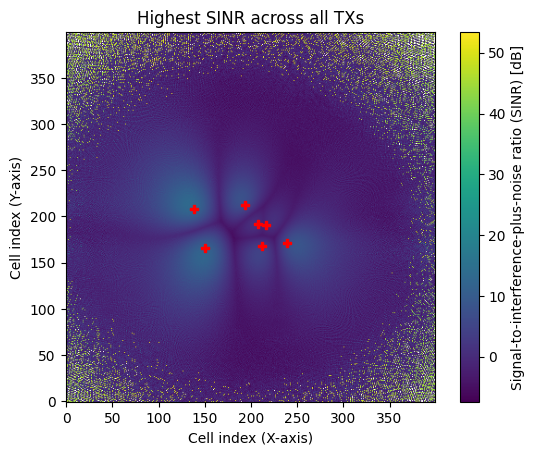

In [13]:
# rm.show(metric="path_gain")
# rm.show(metric="rss")
rm.show(metric="sinr")

print(len(rm.sinr))
print(len(rm.sinr[0]))
print(len(rm.sinr[0][0]))

print(rm.num_rx)
# print(rm.rx_cell_indices)
# print(rm.sinr)

sinr_gu = cache["sinr_db_gu_tx"][t]

print(len(sinr_gu))
print(len(sinr_gu[0]))

print(sinr_gu[0])

flat_idx = np.argmax(sinr_gu)
gu_id, tx_id = np.unravel_index(flat_idx, sinr_gu.shape)

print("max value:", sinr_gu[gu_id, tx_id])
print("at gu_id:", gu_id, "tx_id:", tx_id)
print("that GU row:", sinr_gu[gu_id])

S = np.asarray(rm.sinr)   # shape (n_tx, H, W)
print("rm.sinr shape:", S.shape, "dtype:", S.dtype)

flat_idx = np.argmax(S)
tx_id, row, col = np.unravel_index(flat_idx, S.shape)

print("global max:", S[tx_id, row, col])
print("at (tx, row, col):", (tx_id, row, col))

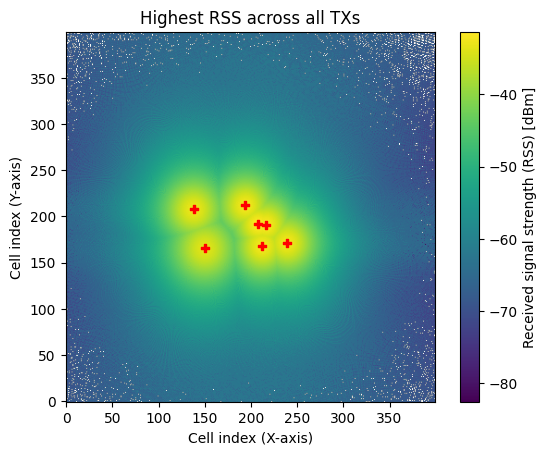

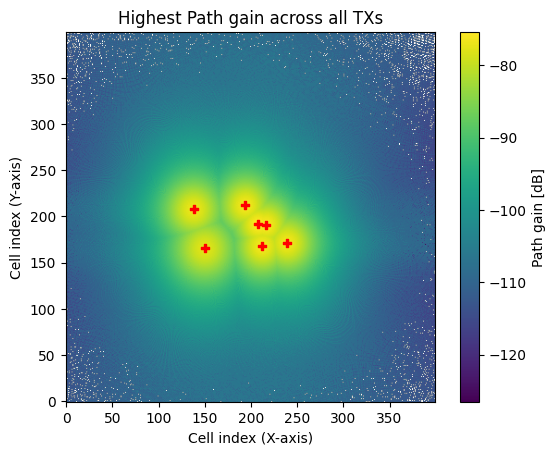

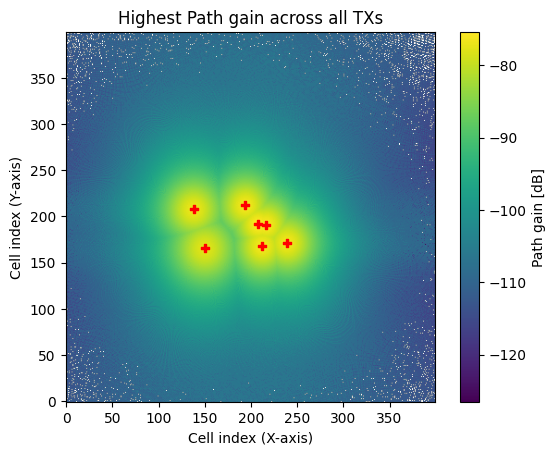

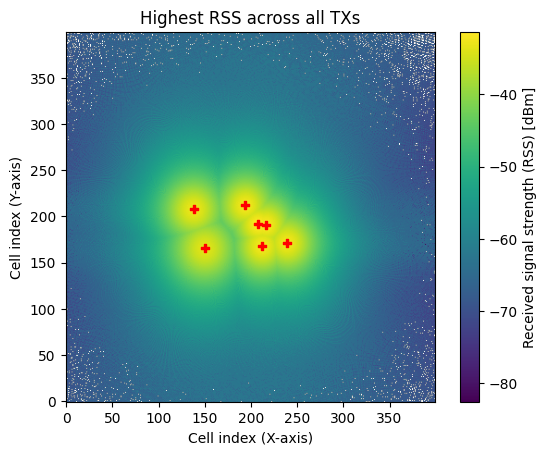

In [19]:
rm.show()
rm.show(metric="path_gain")
rm.show(metric="rss")

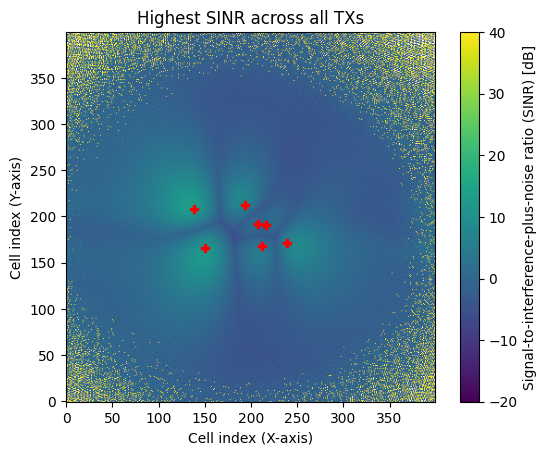

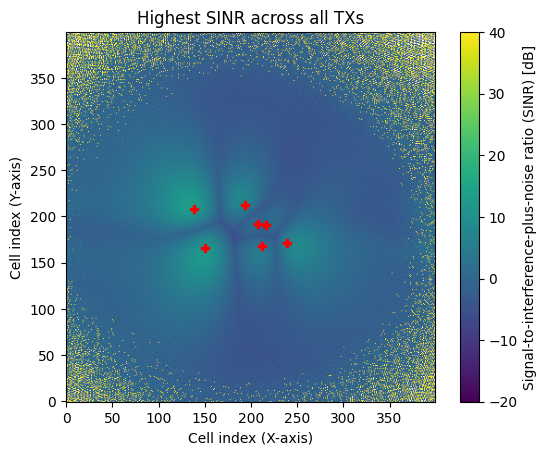

In [14]:
rm.show(metric="sinr", vmin=-20, vmax=40)

In [15]:
rm = cache["radio_map"][t]

print("cell_size:", rm.cell_size.numpy() if hasattr(rm.cell_size, "numpy") else rm.cell_size)
print("cells_per_dim:", rm.cells_per_dim.numpy() if hasattr(rm.cells_per_dim, "numpy") else rm.cells_per_dim)
print("size:", rm.size.numpy() if hasattr(rm.size, "numpy") else rm.size)
print("center:", rm.center.numpy() if hasattr(rm.center, "numpy") else rm.center)
print("num_tx:", rm.num_tx, "num_rx:", rm.num_rx)

tx_pos = getattr(rm, "_tx_positions", None)
if tx_pos is not None:
    tx_pos = np.asarray(tx_pos)
    print("tx_pos shape:", tx_pos.shape)
    print("tx_pos[:3]:\n", tx_pos[:3])

cell_size: [[5.]
 [5.]]
cells_per_dim: [[400]
 [400]]
size: [[2000.]
 [2000.]]
center: [[0. ]
 [0. ]
 [1.5]]
num_tx: 7 num_rx: 150
tx_pos shape: (3, 7)
tx_pos[:3]:
 [[  40.064453  -29.594543   61.41272    81.92944   195.8789   -250.
  -310.      ]
 [ -39.996582   61.666504 -157.46667   -43.116394 -140.08533  -170.
    40.      ]
 [ 120.15755   130.85178   130.6427    126.11446   134.26665   155.
   140.      ]]


/tmp/ipykernel_612848/1488134853.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", n_tx)


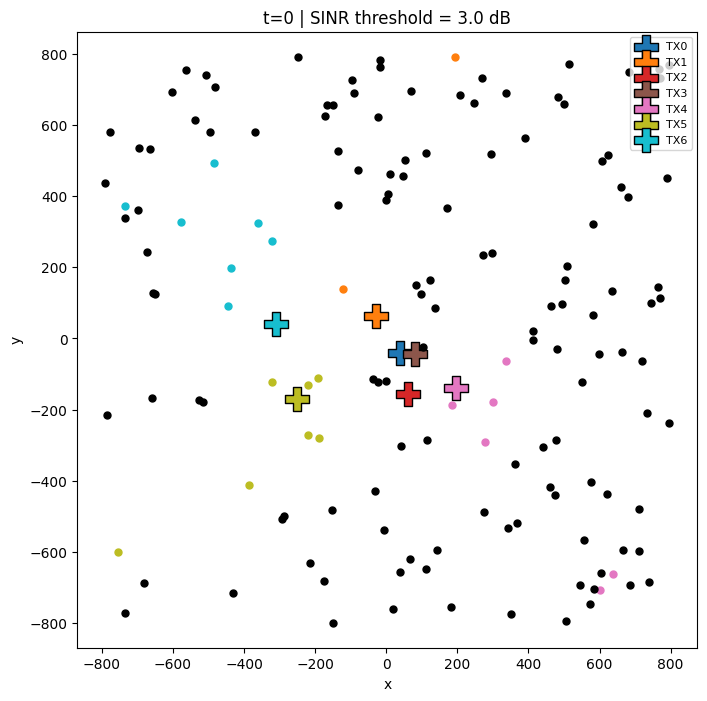

Total GU: 150
Covered GU: 22
Coverage ratio: 0.14666666666666667
Association counts: [ 6 22 14 11 49 24 24]


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_gu_association_single_figure(
    cache,
    gu_traj_csv,
    t=0,
    sinr_threshold_db=10.0,
):
    # ---- 1. 读取 SINR ----
    sinr = np.asarray(cache["sinr_db_gu_tx"][t], dtype=np.float32)
    n_gu, n_tx = sinr.shape

    # ---- 2. 读取 GU 位置 ----
    df = pd.read_csv(gu_traj_csv)
    dft = df[df["t"] == t].copy()
    dft = dft.sort_values("gu_id")

    gu_xy = dft[["x", "y"]].to_numpy(dtype=np.float32)
    if gu_xy.shape[0] != n_gu:
        print(f"[Warn] GU count mismatch: sinr={n_gu}, csv={gu_xy.shape[0]}")

    # ---- 3. 读取 TX 位置 ----
    rm = cache["radio_map"][t]
    tx_pos = getattr(rm, "_tx_positions", None)
    if tx_pos is None:
        raise RuntimeError("Cannot find TX positions from radiomap.")
    tx_xyz = np.asarray(tx_pos, dtype=np.float32).T  # (n_tx,3)
    tx_xy = tx_xyz[:, :2]

    # ---- 4. 计算 best association ----
    best_tx = np.argmax(sinr, axis=1)
    best_sinr = np.max(sinr, axis=1)

    # ---- 5. 生成 TX 颜色 ----
    cmap = plt.cm.get_cmap("tab10", n_tx)
    tx_colors = [cmap(i) for i in range(n_tx)]

    # ---- 6. 绘图 ----
    plt.figure(figsize=(8,8))

    # 6.1 先画 TX
    for tx in range(n_tx):
        plt.scatter(
            tx_xy[tx,0],
            tx_xy[tx,1],
            s=300,
            marker="P",
            color=tx_colors[tx],
            edgecolors="k",
            label=f"TX{tx}"
        )

    # 6.2 再画 GU
    for i in range(n_gu):
        if best_sinr[i] >= sinr_threshold_db:
            color = tx_colors[best_tx[i]]
        else:
            color = "black"

        plt.scatter(
            gu_xy[i,0],
            gu_xy[i,1],
            s=25,
            color=color
        )

    plt.title(f"t={t} | SINR threshold = {sinr_threshold_db} dB")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.legend(loc="upper right", fontsize=8)
    plt.show()

    # ---- 7. 打印统计信息 ----
    covered = best_sinr >= sinr_threshold_db
    print("Total GU:", n_gu)
    print("Covered GU:", np.sum(covered))
    print("Coverage ratio:", np.mean(covered))
    print("Association counts:", np.bincount(best_tx, minlength=n_tx))

plot_gu_association_single_figure(
    cache,
    gu_traj_csv,
    t=0,
    sinr_threshold_db=3.0,
)

In [17]:
# # eval_csv_path = PROJECT_ROOT / "eval_tools/model_a_eval/eval_rollout_raleigh_T50.csv"
# eval_csv_path = PROJECT_ROOT / "eval_tools/model_a_eval/eval_rollout_atlanta_T50.csv"

# # saved = save_eval_csv(df, eval_csv_path)
# # print("Saved eval CSV:", saved)


In [18]:
# t = 10
# gu_xyz = cache["gu_xyz"][t]
# uav_xyz = cache["uav_xyz"][t]

# # 2D
# visualize_scene_2d(CFG_PATH, gu_xyz=gu_xyz, uav_xyz=uav_xyz, title=f"Eval frame t={t} (2D)")

# # 3D
# fig = visualize_scene_3d(CFG_PATH, gu_xyz=gu_xyz, uav_xyz=uav_xyz, title=f"Eval frame t={t} (3D)")
# fig
